In [2]:
%run 0_result_analysis_functions.ipynb

In [3]:
# Import catalog with SimstackWrapper
# 2-sf/qt
combined_pickle_filename = "uVista_DR2_SFQT_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5p0_X_4_foregnd_atonce_"
# 3-agn
combined_pickle_filename = "uVista_DR2_Ahat_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4p0_X_4_foregnd_layers_"
# 3-starburst
#combined_pickle_filename = "uVista_DR2_SB_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4p0_X_4_foregnd_layers_"
# 4
#combined_pickle_filename = "uVista_DR2_Ahat_Starburst_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5p0_X_4_foregnd_layers_"

combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", combined_pickle_filename)
underscore_suffix = "" # "__"
path_ini_file = os.path.join(combined_pickle_path+underscore_suffix, "uvista.ini")
path_pickle_file = os.path.join(combined_pickle_path+underscore_suffix, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [4]:
simstack_maps_object = SimstackWrapper(path_ini_file, save_automatically=False, read_maps=True, read_catalog=False)

In [5]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [6]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [7]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [8]:
simstack_object.config_dict['catalog']['classification'].keys()

dict_keys(['redshift', 'stellar_mass', 'agn_fraction', 'split_params'])

In [9]:
fluxes_dict = parse_fluxes(simstack_object)

In [10]:
fluxes_dict.keys()

dict_keys(['flux', 'error', 'wavelengths'])

In [11]:
np.shape(fluxes_dict['flux'])

(7, 8, 4, 5, 2)

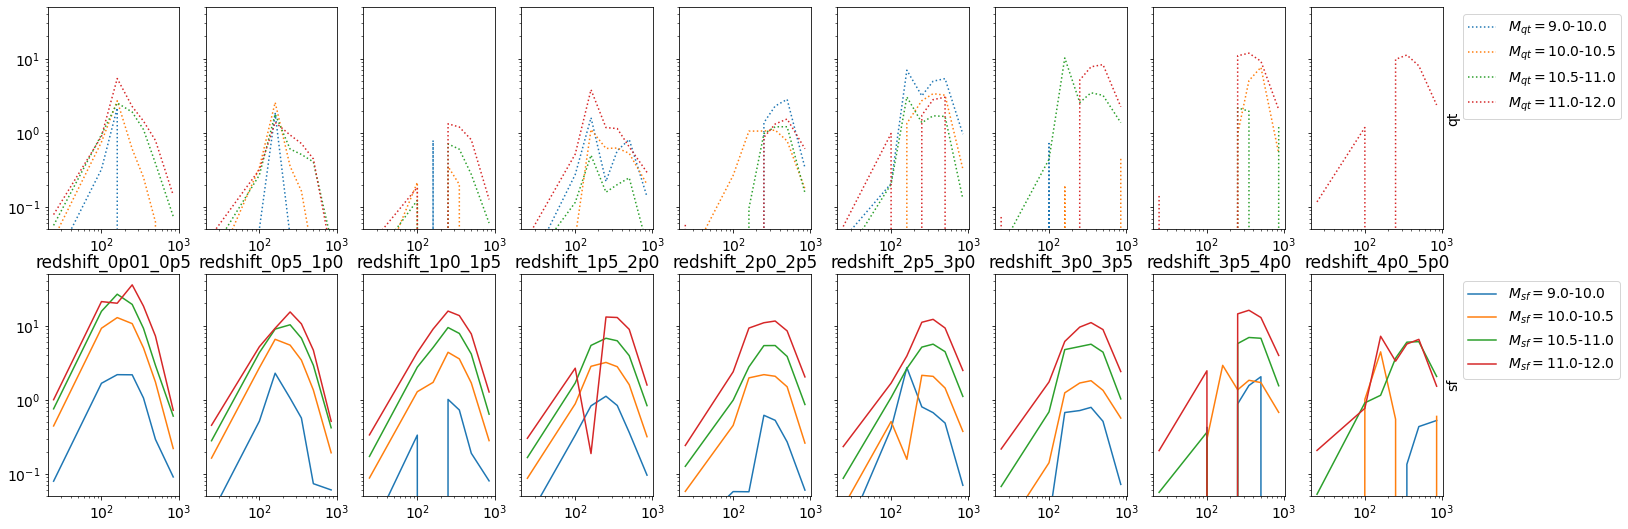

In [11]:
plot_pops(simstack_object)

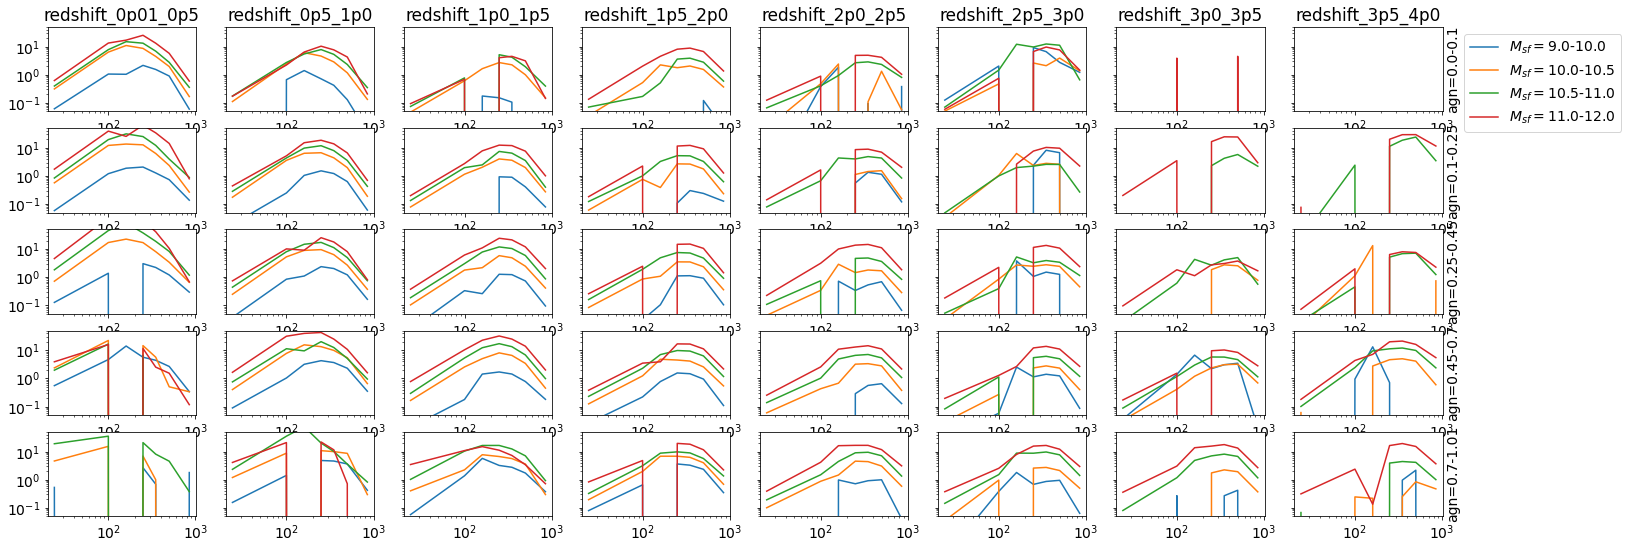

In [12]:
plot_pops(simstack_object)

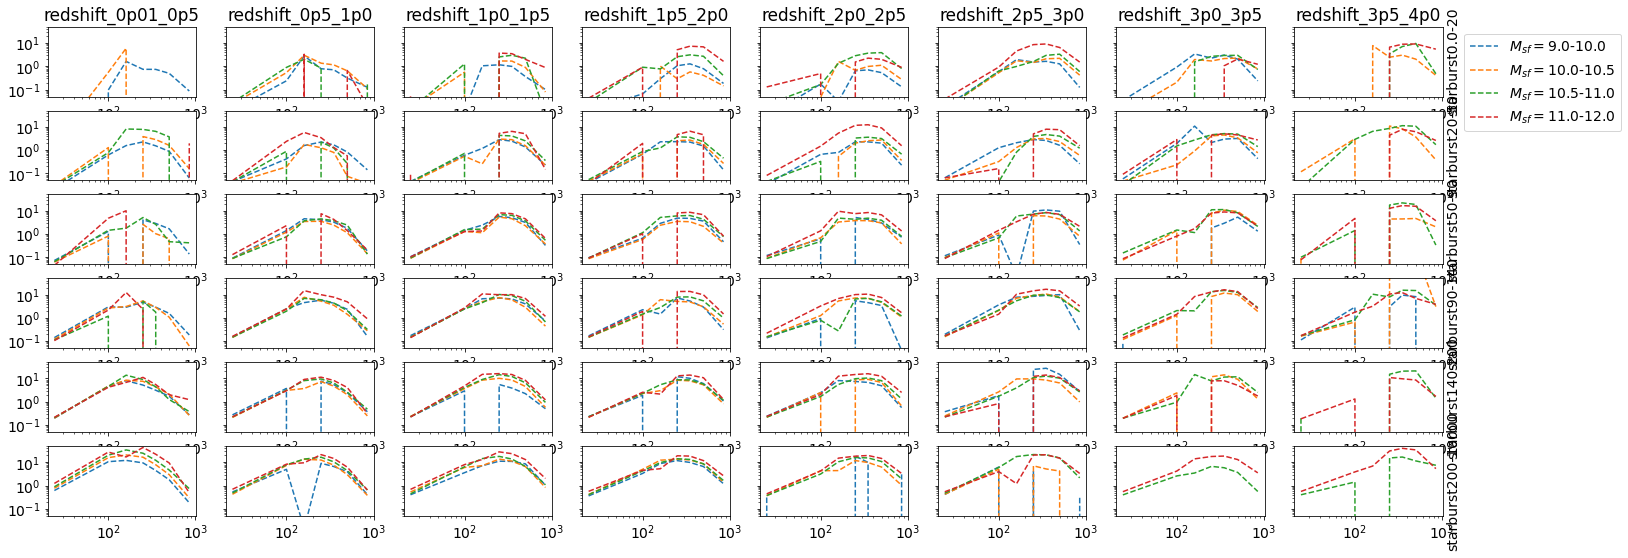

In [11]:
plot_pops(simstack_object)

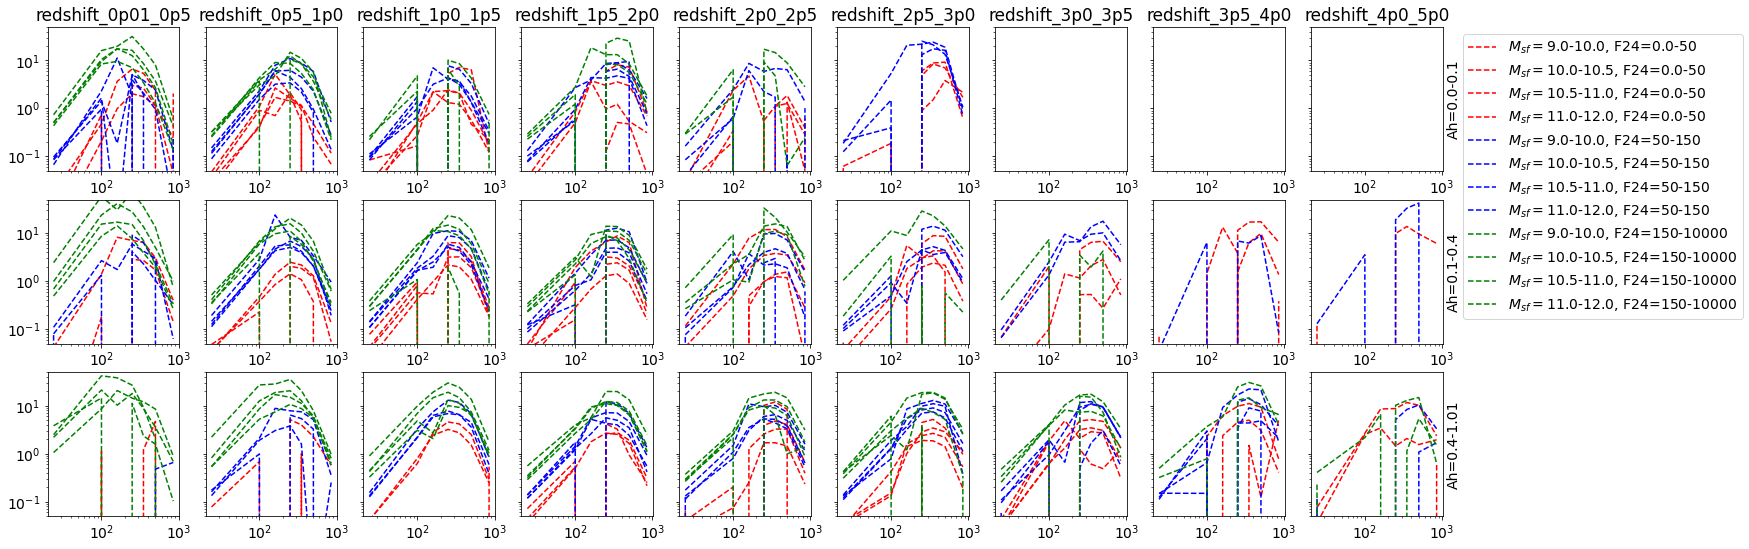

In [11]:
plot_pops(simstack_object)

In [11]:
# SLOW!
sed_dict = get_fast_sed_dict(simstack_object, fluxes_dict, simstack_catalog_object)

In [12]:
sed_dict.keys()

dict_keys(['wv_array', 'sed_params', 'graybody', 'lir', 'redshift', 'stellar_mass', 'agn_fraction', 'split_params'])

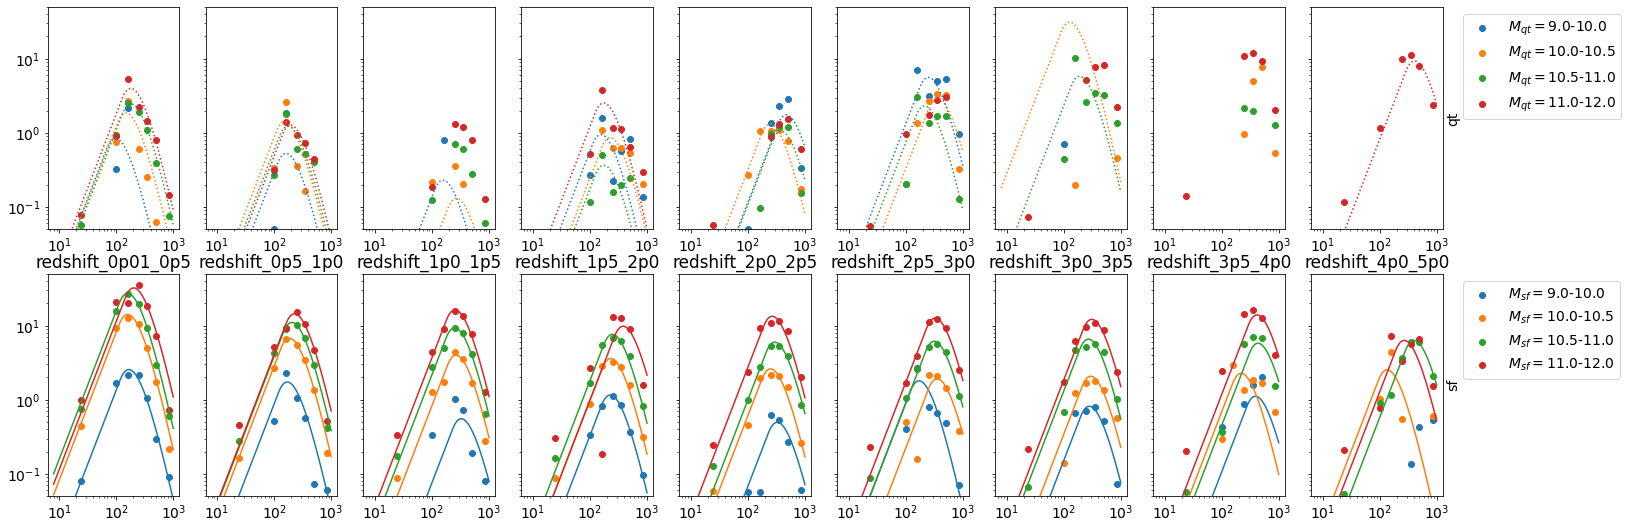

In [14]:
plot_pops(simstack_object,sed_dict=sed_dict)

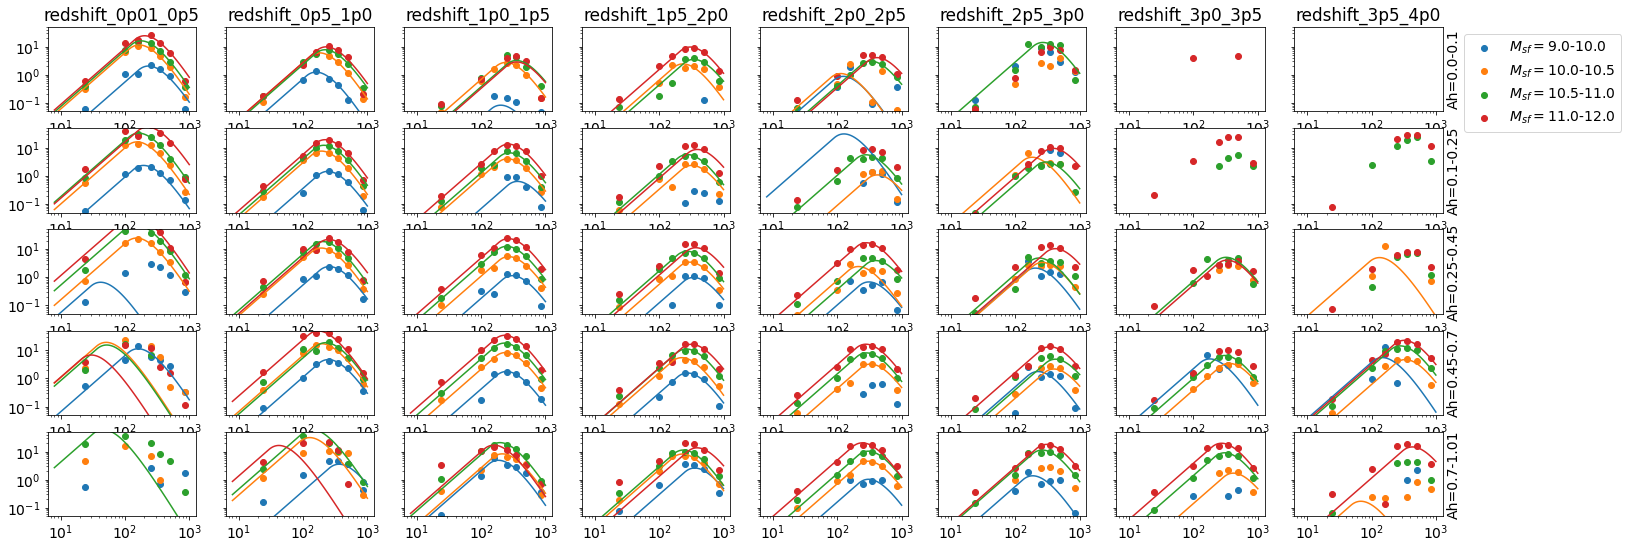

In [14]:
plot_pops(simstack_object,sed_dict=sed_dict)

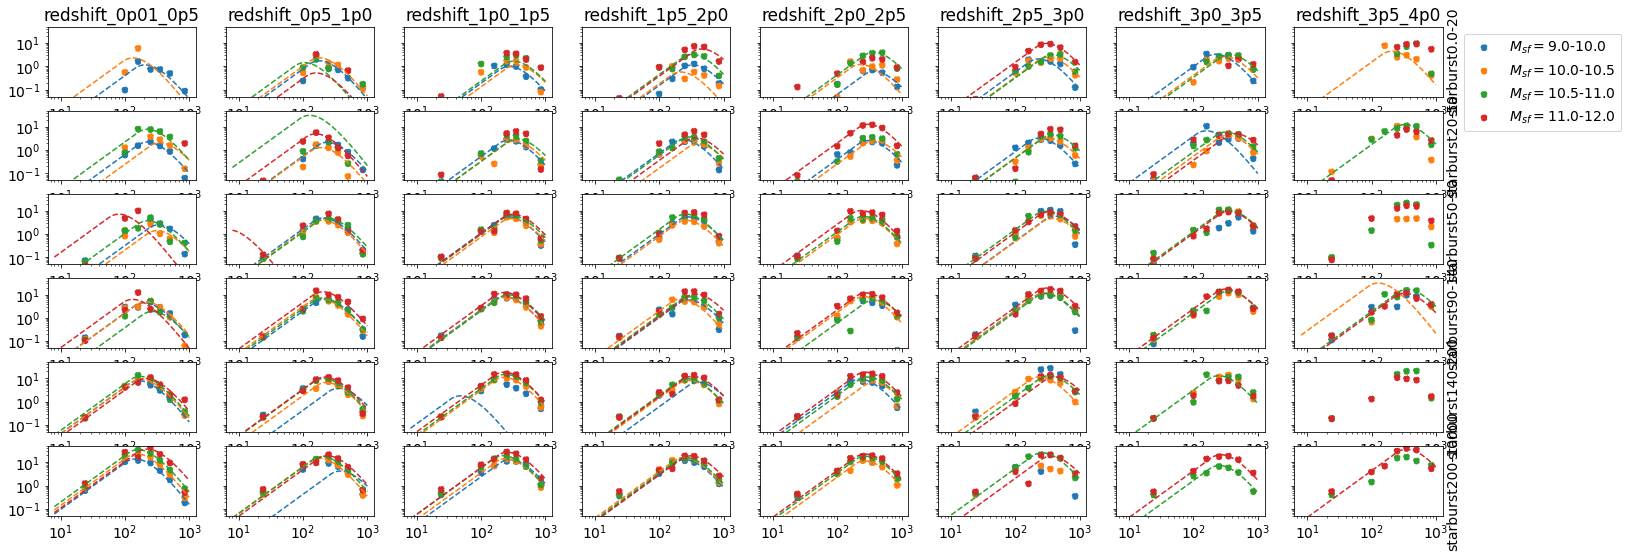

In [14]:
plot_pops(simstack_object,sed_dict=sed_dict)

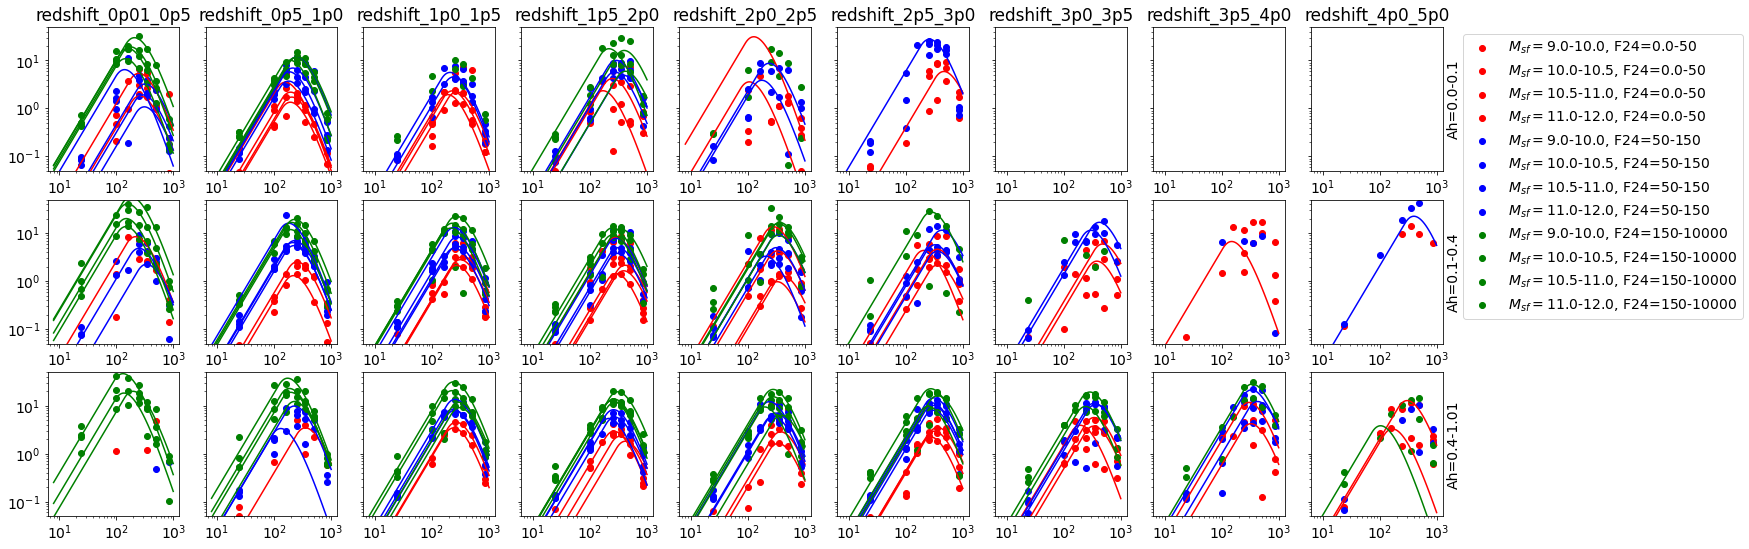

In [22]:
plot_pops(simstack_object, sed_dict=sed_dict)

In [14]:
As = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_0' not in i])
Ts = np.array([sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_0' not in i])

#Ms = np.array([10**sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Ms = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Zs = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_0' not in i])

In [15]:
try:
    AGNs = np.array([sed_dict['agn_fraction'][i] for i in sed_dict['agn_fraction'] if 'params_0' not in i])
except:
    pass
try:
    SBs = np.array([sed_dict['starburst'][i] for i in sed_dict['starburst'] if 'params_0' not in i])
except:
    pass
LIRs = np.array([np.log10(sed_dict['lir'][i]) for i in sed_dict['lir'] if 'params_0' not in i])

In [26]:
idx_keep = (As > -36) & (Ts * (1+Zs) < 90)
try:
    cube = np.array([Zs[idx_keep],Ms[idx_keep]])
except:
    pass
try:
    cube = np.array([Zs[idx_keep],Ms[idx_keep],AGNs[idx_keep]])
except:
    pass
try:
    cube = np.array([Zs[idx_keep],Ms[idx_keep],SBs[idx_keep]])
except:
    pass
try:
    cube = np.array([Zs[idx_keep],Ms[idx_keep],AGNs[idx_keep],SBs[idx_keep]])
except:
    pass

In [27]:
def model_A_Tdust(params, X, qt=False):
    v = params.valuesdict().copy()
    if 'offset' in v:
        model = v.pop('offset')
    else:
        model = 0 
    if 'slope_split_params' in v:
        pop = v.pop('slope_split_params')
        if qt:
            model+=X[-1]*pop
            
    for i, ival in enumerate(v):
        model+= X[i] * v[ival]
    return model

In [28]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube,),
                     kws={'y': As[idx_keep]},
                     nan_policy='propagate')
cov_Tdust = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube,),
                     #kws={'y': Ts[idx_keep] * (1 + Zs[idx_keep])},
                     kws={'y': Ts[idx_keep]},
                     nan_policy='propagate')

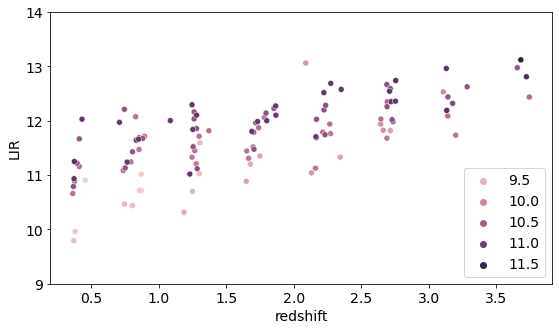

In [29]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
#fig=sns.scatterplot(Zs,LIRs,hue=np.log10(Ms))
#fig=sns.scatterplot(Zs,LIRs,hue=Ms)
fig=sns.scatterplot(Zs[idx_keep],LIRs[idx_keep],hue=Ms[idx_keep])
fig.set(ylim=(9,14))
fig.set(ylabel='LIR')
fig.set(xlabel='redshift');

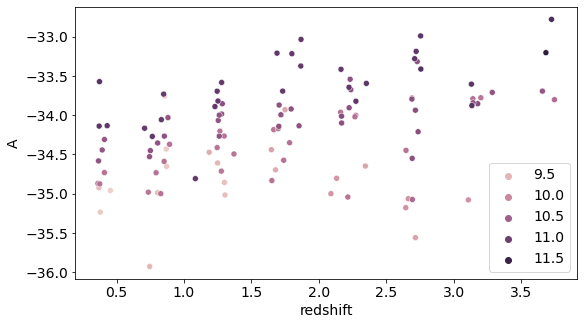

In [30]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs[idx_keep],As[idx_keep], hue=Ms[idx_keep])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');

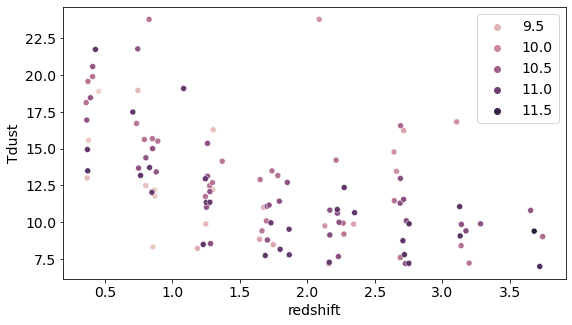

In [31]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
#fig=sns.scatterplot(Zs, Ts*(1+Zs), hue=np.log10(Ms))
#fig=sns.scatterplot(Zs[idx_keep], Ts[idx_keep]*(1+Zs[idx_keep]), hue=Ms[idx_keep])
fig=sns.scatterplot(Zs[idx_keep], Ts[idx_keep], hue=Ms[idx_keep])
#fig.set(ylim=(10,60))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift');

In [32]:
cov_Adust

In [33]:
cov_Tdust

In [34]:
catalog_keys

['z_peak', 'LMASS', 'a_hat_AGN']

In [71]:
np.shape(model_cube)

(3, 166633)

In [74]:
np.shape(simstack_catalog_object.catalog_dict['tables']['split_table'])

(166633, 6)

In [75]:
simstack_catalog_object.catalog_dict['tables']['split_table'].head()

ra       dec  redshift  stellar_mass  agn_fraction  split_params
0  149.62285  1.692682       NaN           NaN           4.0             1
1  149.42641  2.467277       NaN           NaN           0.0             1
2  149.62099  1.696837       NaN           NaN           2.0             1
3  150.38873  2.437387       NaN           NaN           2.0             1
4  150.40459  2.407113       NaN           NaN           1.0             1

In [35]:
model_cube = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys]

In [36]:
model_cube = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys]
#model_cube['LMASS'] = 10**model_cube['LMASS']
model_cube['LMASS'] = model_cube['LMASS']
model_cube = model_cube.to_numpy().T

In [37]:
spire_250 = simstack_maps_object.maps_dict['spire_psw']

In [38]:
A_model = model_A_Tdust(cov_Adust.params, model_cube)
T_model = model_A_Tdust(cov_Tdust.params, model_cube)
sed_model_params = {'A':cov_Adust.params, 'Tdust':cov_Tdust.params}

In [39]:
A_model

array([-38.69183142, -38.59766002, -38.45708557, ..., -32.86170436,
       -32.79202601, -32.43628132])

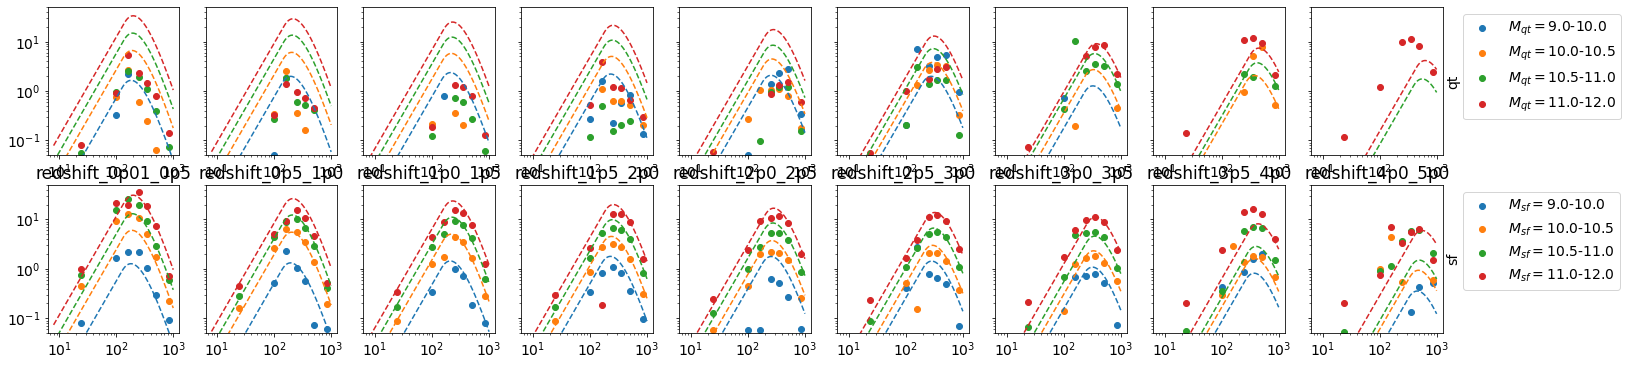

In [66]:
plot_pops(simstack_object,sed_dict=sed_dict, sed_model_params=sed_model_params)

In [45]:
def plot_pops(self, sed_dict=None, sed_model_params=None):
    fluxes_dict = self.parse_fluxes()
    #fluxes_dict = parse_fluxes(self)
    wavelengths = fluxes_dict['wavelengths'] #[24, 100, 160, 250, 350, 500, 850]
    wavelength_keys = list(self.results_dict['band_results_dict'].keys())
    split_dict = self.config_dict['catalog']['classification']
    # split_type = split_dict.pop('split_type')
    label_keys = list(split_dict.keys())
    label_dict = self.config_dict['parameter_names']
    ds = [len(label_dict[k]) for k in label_dict]

    if len(ds) > 3:
        fig, axs = plt.subplots(ds[-2], ds[0], figsize=(25,9))
    else:
        fig, axs = plt.subplots(ds[-1], ds[0], figsize=(25,6))
    
    ls = [ ':','-','--']
    pop = ['qt', 'sf']
    color = ['r', 'b', 'g', 'k']
    for z, zval in enumerate(self.config_dict['catalog']['distance_labels']):
        if len(label_keys) == 5:
            for l, lval in enumerate(label_dict[label_keys[4]]):
                for iagn, agn_val in enumerate(label_dict[label_keys[3]]):
                    for isb, sb_val in enumerate(label_dict[label_keys[2]]):
                        for imass, m_val in enumerate(label_dict[label_keys[1]]):
                            id_label = "__".join([zval, m_val, sb_val, agn_val, lval]).replace('.', 'p')

                            label = None
                            if l and not iagn and z == len(label_dict[label_keys[0]])-1:
                                label = "$M_{"+pop[l]+"}=$"+"-".join(m_val.split('_')[-2:])+", F24="+"-".join(sb_val.split('_')[-2:])
                            if l and sed_dict is None:
                                axs[iagn, z].plot(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,isb,iagn,l], ls=ls[l], color=color[isb], label=label)
                                
                            if l and (sed_dict is not None):
                                sed_params = sed_dict['sed_params'][id_label]
                                lir_mod = np.log10(sed_dict['lir'][id_label])
                                wv_mod = sed_dict['wv_array']
                                gb_mod = sed_dict['graybody'][id_label]
                                axs[iagn, z].scatter(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,isb, iagn,l], color=color[isb], label=label)
                                if sed_model_params is None:
                                    axs[iagn, z].plot(wv_mod, 1e3*gb_mod, ls=ls[l], color=color[isb])

                            if l and (sed_model_params is not None):
                                wv_mod = sed_dict['wv_array']
                                model_cube = np.array([sed_dict['redshift'][id_label],
                                                       sed_dict['stellar_mass'][id_label],
                                                       sed_dict['agn_fraction'][id_label],
                                                       sed_dict['starburst'][id_label]]).T
                                A_model = model_A_Tdust(sed_model_params['A'], model_cube)
                                T_model = model_A_Tdust(sed_model_params['Tdust'], model_cube)
                                theta_model = A_model, T_model
                                gb_model = graybody_fn(self, theta_model, wv_mod)
                                axs[iagn, z].plot(wv_mod, 1e3*gb_model[0], ls=ls[isb], color=color[isb])
                                
                            axs[iagn, z].set_ylim([5e-2, 5e1])
                            axs[iagn, z].set_xscale('log')
                            axs[iagn, z].set_yscale('log')
                            if z:
                                axs[iagn, z].set_yticklabels([])
                            if not iagn:
                                axs[iagn, z].set_title(zval)
                            if z == len(label_dict[label_keys[0]])-1:
                                ylabel = "Ah="+"-".join(agn_val.split('_')[-2:])
                                axs[iagn, z].set_ylabel(ylabel)
                                axs[iagn, z].yaxis.set_label_position("right")

                            if l and not iagn and z == len(label_dict[label_keys[0]])-1:
                                axs[iagn, z].legend(bbox_to_anchor=(1.1,1), loc="upper left")  
                                
        elif len(label_keys) == 4:
            for l, lval in enumerate(label_dict[label_keys[3]]):
                for iagn, agn_val in enumerate(label_dict[label_keys[2]]):
                    for imass, m_val in enumerate(label_dict[label_keys[1]]):
                        id_label = "__".join([zval, m_val, agn_val, lval]).replace('.', 'p')
                        #print(label)

                        label = None
                        if l and not iagn and z == len(label_dict[label_keys[0]])-1:
                            label = "$M_{"+pop[l]+"}=$"+"-".join(m_val.split('_')[-2:])
                        if l and sed_dict is None:
                            axs[iagn, z].plot(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,iagn,l], ls=ls[l], label=label)
                            
                        if l and (sed_dict is not None):
                            sed_params = sed_dict['sed_params'][id_label]
                            lir_mod = np.log10(sed_dict['lir'][id_label])
                            wv_mod = sed_dict['wv_array']
                            gb_mod = sed_dict['graybody'][id_label]
                            axs[iagn, z].scatter(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,iagn,l], label=label)
                            if sed_model_params is None:
                                axs[iagn, z].plot(wv_mod, 1e3*gb_mod, ls=ls[l])
                            
                        if l and (sed_model_params is not None):
                            wv_mod = sed_dict['wv_array']
                            if 'agn' in label_keys[2]:
                                model_cube = np.array([sed_dict['redshift'][id_label],sed_dict['stellar_mass'][id_label],sed_dict['agn_fraction'][id_label]]).T
                            else:
                                model_cube = np.array([sed_dict['redshift'][id_label],sed_dict['stellar_mass'][id_label],sed_dict['starburst'][id_label]]).T
                            A_model = model_A_Tdust(sed_model_params['A'], model_cube)
                            T_model = model_A_Tdust(sed_model_params['Tdust'], model_cube)
                            theta_model = A_model, T_model
                            gb_model = graybody_fn(self, theta_model, wv_mod)
                            axs[iagn, z].plot(wv_mod, 1e3*gb_model[0], ls='--')

                        axs[iagn, z].set_ylim([5e-2, 5e1])
                        axs[iagn, z].set_xscale('log')
                        axs[iagn, z].set_yscale('log')
                        if z:
                            axs[iagn, z].set_yticklabels([])
                        if not iagn:
                            axs[iagn, z].set_title(zval)
                        if z == len(label_dict[label_keys[0]])-1:
                            ylabel = agn_val.split('_')[0]+"="+"-".join(agn_val.split('_')[-2:])
                            axs[iagn, z].set_ylabel(ylabel)
                            axs[iagn, z].yaxis.set_label_position("right")

                        if l and not iagn and z == len(label_dict[label_keys[0]])-1:
                            axs[iagn, z].legend(bbox_to_anchor=(1.1,1), loc="upper left")
                            
        elif len(label_keys) == 3:
            for l, lval in enumerate(label_dict[label_keys[2]]):
                for imass, m_val in enumerate(label_dict[label_keys[1]]):
                    id_label = "__".join([zval, m_val, lval]).replace('.', 'p')

                    label = None
                    if z == len(label_dict[label_keys[0]])-1:
                        label = "$M_{"+pop[l]+"}=$"+"-".join(m_val.split('_')[-2:])
                    if sed_dict is None:
                        axs[l, z].plot(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,l], ls=ls[l], label=label)
                    
                    if sed_dict is not None:
                        sed_params = sed_dict['sed_params'][id_label]
                        lir_mod = np.log10(sed_dict['lir'][id_label])
                        wv_mod = sed_dict['wv_array']
                        gb_mod = sed_dict['graybody'][id_label]
                        axs[l, z].scatter(wavelengths, 1e3*fluxes_dict['flux'][:,z,imass,l], label=label)
                        if sed_model_params is None:
                            axs[l, z].plot(wv_mod, 1e3*gb_mod, ls=ls[l])
                        
                    if (sed_model_params is not None):
                        wv_mod = sed_dict['wv_array']
                        model_cube = np.array([sed_dict['redshift'][id_label],sed_dict['stellar_mass'][id_label]]).T
                        A_model = model_A_Tdust(sed_model_params['A'], model_cube)
                        T_model = model_A_Tdust(sed_model_params['Tdust'], model_cube)
                        theta_model = A_model, T_model
                        gb_model = graybody_fn(self, theta_model, wv_mod)
                        axs[l, z].plot(wv_mod, 1e3*gb_model[0], ls='--')

                    axs[l, z].set_ylim([5e-2, 5e1])
                    axs[l, z].set_xscale('log')
                    axs[l, z].set_yscale('log')
                    if z:
                        axs[l, z].set_yticklabels([])
                    if l:
                        axs[l, z].set_title(zval)
                    if z == len(label_dict[label_keys[0]])-1:
                        ylabel = pop[l]
                        axs[l, z].set_ylabel(ylabel)
                        axs[l, z].yaxis.set_label_position("right")

                    if z == len(label_dict[label_keys[0]])-1:
                        axs[l, z].legend(bbox_to_anchor=(1.1,1), loc="upper left")

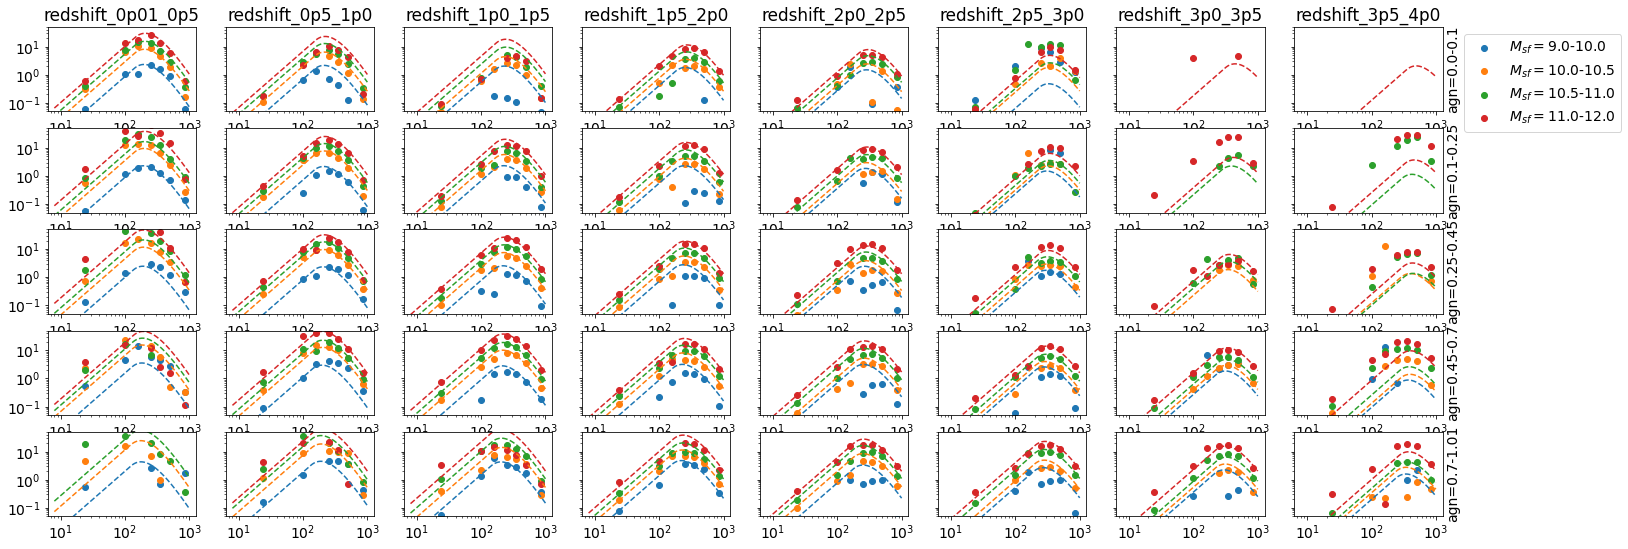

In [46]:
plot_pops(simstack_object,sed_dict=sed_dict, sed_model_params=sed_model_params)

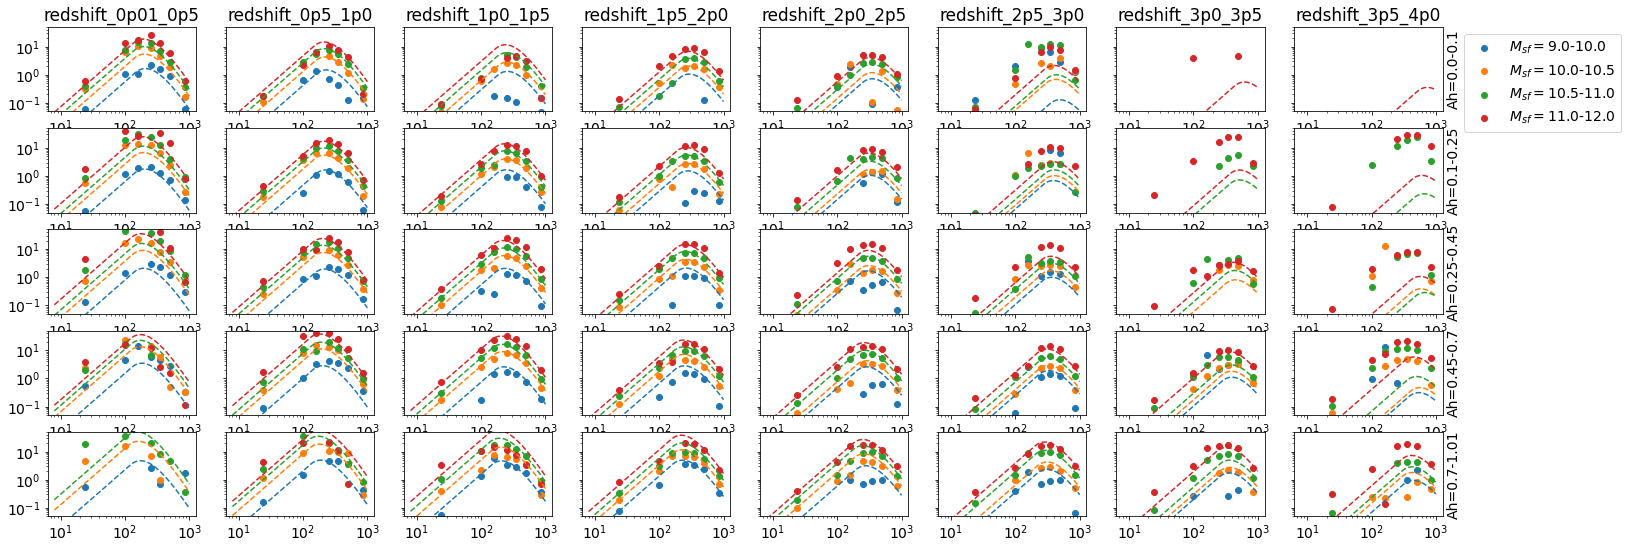

In [65]:
plot_pops(simstack_object,sed_dict=sed_dict, sed_model_params=sed_model_params)

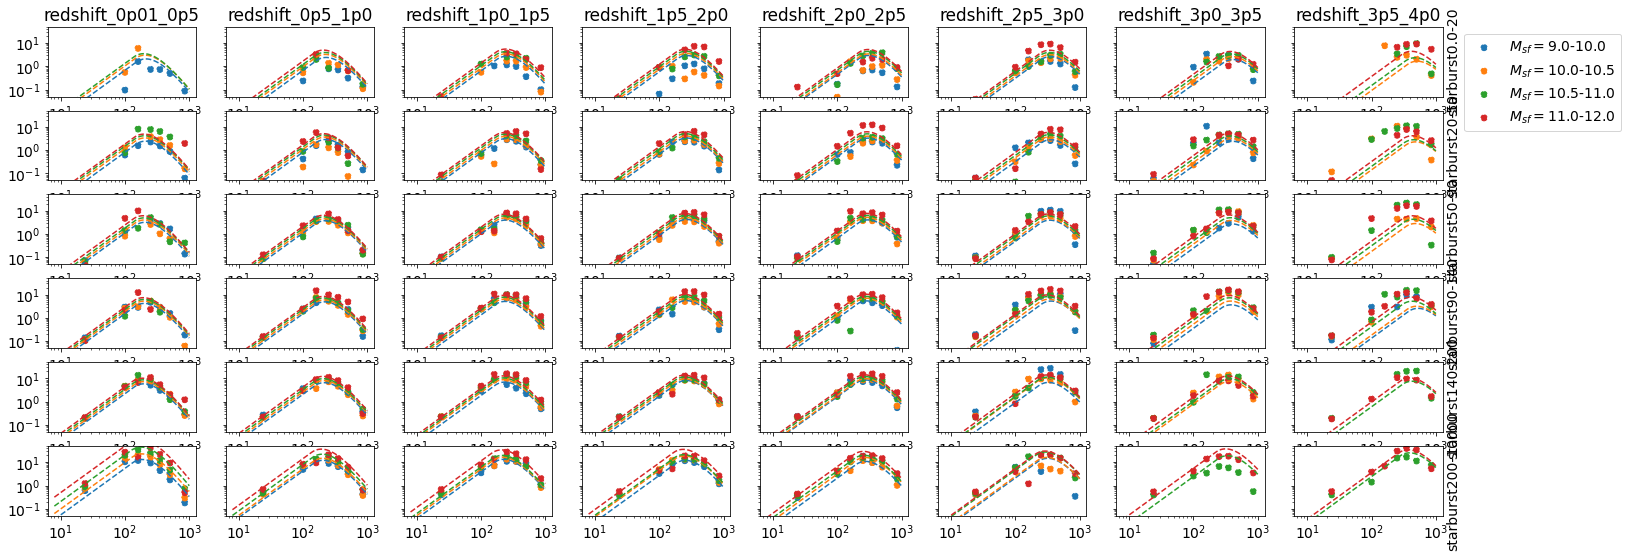

In [31]:
plot_pops(simstack_object,sed_dict=sed_dict, sed_model_params=sed_model_params)

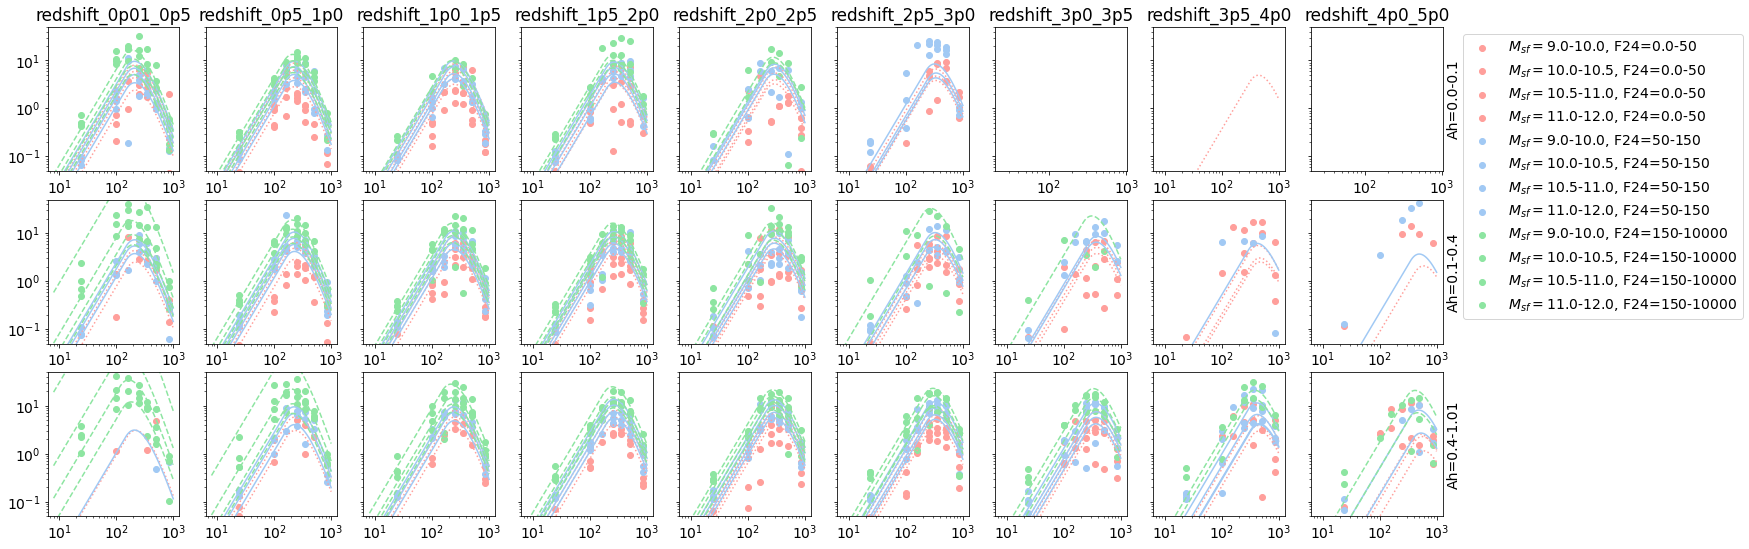

In [128]:
plot_pops(simstack_object,sed_dict=sed_dict, sed_model_params=sed_model_params)

# Make Simmap

In [60]:
z_model = simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak']
idx_sim = ((A_model > -34) & (A_model < -32.5)) & (T_model * (1+z_model) < 90)

In [61]:
ra = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sim]['ra']
dec = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sim]['dec']
x, y = get_x_y_from_ra_dec(spire_250, ra, dec)

In [62]:
def get_flux_mJy(self, nu_in, Ain, T, betain=1.8, alphain=2.0):
    
    A = 10**Ain
    ng = np.size(A)

    ns = len(nu_in)
    base = 2.0 * (6.626)**(-2.0 - betain - alphain) * (1.38)**(3. + betain + alphain) / (2.99792458)**2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0**expo
    w_num = A * K * (T * (3.0 + betain + alphain))**(3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num/w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T

    graybody = A * nu_in**betain * self.black(nu_in, T)[:,0] / 1000. 
    powerlaw = w_div * nu_in**(-1.0 * alphain)
    ind_cut = nu_in > nu_cut
    #pdb.set_trace()
    if np.sum(ind_cut):
        graybody[ind_cut] = powerlaw[ind_cut]
    
    #pdb.set_trace()
    return graybody

In [63]:
get_flux_mJy(simstack_object, np.array([nu_mod]),-35,13.9)

array([0.00226613])

In [64]:
A_model[idx_sim]

array([-33.99209662, -33.98440512, -33.90794289, ..., -32.77351837,
       -32.86170436, -32.79202601])

In [65]:
T_model[idx_sim]

array([ 7.4072853 ,  7.93992077,  6.73825116, ...,  7.12834198,
       10.58294495,  4.67978986])

In [66]:
lambda_mod = spire_250['wavelength']
nu_mod = c * 1.e6/lambda_mod
S_250 = get_flux_mJy(simstack_object, np.array([nu_mod]),A_model[idx_sim],T_model[idx_sim])

In [67]:
S_250

array([0.00064191, 0.00104769, 0.00040932, ..., 0.00817885, 0.08412028,
       0.00044813])

In [68]:
model_250 = np.zeros_like(spire_250['map'])
model_250[x,y]=S_250

In [69]:
map_name = 'spire_psw'
write_fits(simstack_maps_object, map_name)

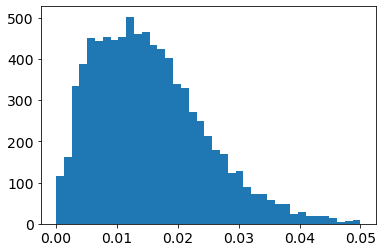

In [70]:
plt.hist(S_250, bins=np.linspace(5e-6,5e-2,40));


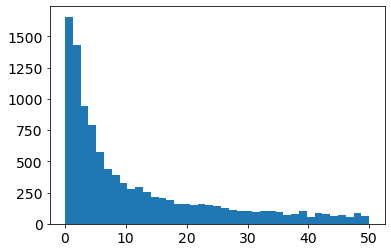

In [96]:
plt.hist(S_250, bins=np.linspace(5e-6,5e1,40));
